## Problemi su grafo 2: il Traveling Salesperson Problem (TSP)

Trova il circuito Hamiltoniano (che tocca tutti i vertici una e una sola volta) più corto attraverso i nodi $n$ dove è nota la distanza tra due nodi qualsiasi. 
<br /><b>Appunti:</b><br />
Commesso viaggiatore vuole toccare tutti i nodi spendendo meno benzina possibile.
Ciclo Hamiltoniano perché tocca tutti i nodi del grafo (una sola volta)
x(ij)= sì/no (1/0)
<br />
FLUSSO ENTRANTE = FLUSSO USCENTE
<br /> per ogni nodo flusso uscente = 1, almeno viola il vincolo. <br /> SOTTOINSIEMI NODI = genera un taglio
<br /><b>Algoritmo:</b>

1. Generate $k$ punti creando coordinate $x,y$ casuali per ciascuno; le coordinate dovrebbero essere nell'intervallo $[0,100]$;
2. Si supponga che il grafo $G = (V,A)$ su cui risolvere il TSP sia _completo_, ovvero che due coppie qualsiasi siano sempre collegate da un arco;
3. Create il modello di ottimizzazione per il TSP aggiungendo solo vincoli di _conservazione del flusso_, ovvero non aggiungere alcun vincolo di eliminazione di eventuali sotto-tour;
4. Risolvete in modo iterativo il modello di ottimizzazione e quindi aggiungete i vincoli di eliminazione del sottotour fino a quando la soluzione è un unico tour (ottimale).

## Soluzione

Similmente al Problema 1 (percorso più breve), eseguiremo un passaggio alla volta e visualizzeremo ciò che otteniamo per fornire un'intuizione per ogni passaggio. Useremo un codice simile per creare le coordinate.

In [3]:
# Sia su Jupyter che su Colab, a seconda delle impostazioni, può non essere necessario reinstallare mip
# Se questo comando vi dà errore, commentatelo e ignoratelo
!pip install mip
!pip install --upgrade pip


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 523.8 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
      Successfully uninstalled pip-22.2.2


In [15]:
import numpy as np
import math

k = 7  # numero dei nodi

grid_size = 100 # dimensione della griglia dei punti

np.random.seed(2)
#np.random.seed(18) # ! Lasciate commentata quest'istruzione per ora

# Creiamo k punti casuali con due coordinate. Moltiplicando per grid_size
# genera numeri casuali compresi tra 0 e 100.
point = grid_size * np.random.random((k,2))

# TODO: Definite l'insieme dei vertici del grafico come l'elenco di numeri da 0 a k-1
V = range(k)

# TODO: Calcolate la distanza per ogni coppia di punti
#
distance = {(i,j): math.sqrt((point[j,0]-point[i,0])**2+(point[j,1] - point[i,1])**2) for i  in V for j in V}

distance[2,5]

print(distance)
a=math.sqrt(2)
a**2

{(0, 0): 0.0, (0, 1): 42.48829653490087, (0, 2): 30.480944115992546, (0, 3): 63.68509007229413, (0, 4): 27.680673862739745, (0, 5): 53.61927152193104, (0, 6): 57.32846949407334, (1, 0): 42.48829653490087, (1, 1): 0.0, (1, 2): 16.655180389730422, (1, 3): 39.09880180005894, (1, 4): 30.148715858147344, (1, 5): 11.79418966662619, (1, 6): 42.239491933592106, (2, 0): 30.480944115992546, (2, 1): 16.655180389730422, (2, 2): 0.0, (2, 3): 36.05812745441626, (2, 4): 13.639966186766653, (2, 5): 28.254438763146354, (2, 6): 33.94890368662383, (3, 0): 63.68509007229413, (3, 1): 39.09880180005894, (3, 2): 36.05812745441626, (3, 3): 0.0, (3, 4): 36.50242499722711, (3, 5): 42.612572598194674, (3, 6): 12.680930027915187, (4, 0): 27.680673862739745, (4, 1): 30.148715858147344, (4, 2): 13.639966186766653, (4, 3): 36.50242499722711, (4, 4): 0.0, (4, 5): 41.491916573070036, (4, 6): 29.687648275871393, (5, 0): 53.61927152193104, (5, 1): 11.79418966662619, (5, 2): 28.254438763146354, (5, 3): 42.612572598194674

2.0000000000000004

Tracciamo questi punti sulla griglia. Usiamo `matplotlib` e in particolare la funzione `matplotlib.pyplot`. Quindi, creiamo un grafico completo e lo disegniamo sulla griglia.

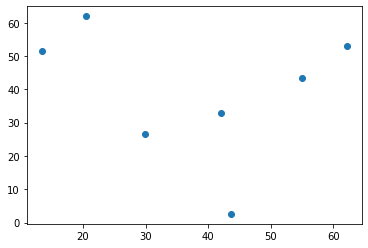

In [10]:
import matplotlib.pyplot as plot
plot.scatter(point[:,0], point[:,1])
plot.show()

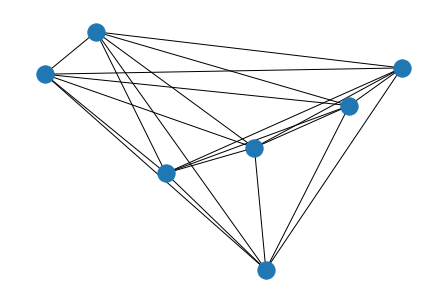

In [17]:
import networkx as nx

V = [i for i in range(k)]  # Insieme dei nodi

# Insieme dei lati: la condizione i<j implica che sono lati, non archi, ovvero
# che non sono direzionati.
E = [(i,j) for i in V for j in V if i < j]

# Creiamo un dizionario che abbia i nodi come chiavi e le tuple delle loro 
# coordinate (x,y) come valori
coord = {i: (point[i,0], point[i,1]) for i in V}

g = nx.Graph()

g.add_nodes_from(V)
g.add_edges_from(E)

nx.draw(g, pos=coord)

Abbiamo tutti i dati di cui abbiamo bisogno e procediamo alla creazione di un modello MIP per il TSP. Scriviamo quello completo, con l'insieme esponenzialmente grande di vincoli di eliminazione del sottotour:

$$
\begin{array}{lll}
   \min & \sum_{(i,j) \in E} d_{ij} x_{ij}\\
   \textrm{s.t.} & \sum_{j \in V: (i,j) \in E} x_{ij} = 2 & \forall i\in V\\
                 & \sum_{(i,j) \in E: i\in C, j\in C} x_{ij} \le |C| - 1 & \forall C\subset V: C \neq \emptyset\\
                 & x_{ij} \in \{0,1\} & \forall (i,j) \in E
\end{array}
$$

Nella prima versione del nostro modello, non includeremo alcun vincolo di eliminazione del sottotour ma aggiungeremo solo il primo set.

In [18]:
# TODO: Create un modello, e aggiungetevi le variabili x
# il secondo s.t. ci dice che non possiamo eccedere la cardinalità-1
# ad esempio in un triangolo (cardinalità 3 per 3 nodi) non possiamo avere piu di 2 lati, altrimenti ho ciclo
import mip
m = mip.Model()

x={(i,j): m.add_var(var_type=mip.BINARY) for (i,j) in E}

I vincoli di conservazione del flusso richiedono che il flusso in entrata sia uguale al flusso in uscita. Invece di aggiungere questi vincoli in un ciclo, li aggiungiamo usando un generatore.

In [19]:
# TODO: Aggiungete i vincoli di conservazione del flusso
for i in V:
    m.add_constr(mip.xsum(x[h,j] for (h,j) in E if i==n)
                + mip.xsum(x[j,h] for (j,h) in E if j==h) ==2)

NameError: name 'n' is not defined

La funzione obiettivo è la stessa del problema precedente: la somma su tutti gli archi $(i,j)$ della loro lunghezza $d_{ij}$ (cioè la distanza tra i nodi $i$ e $j$) moltiplicata per il variabile $x_{ij}$.

In [25]:
# TODO: Aggiungete la funzione obiettivo e risolvete il problema
m.objextive = mip.minimize(distance[i,j] for i in V for j in V)
m.optimize()

AttributeError: 'generator' object has no attribute 'sense'

Possiamo riscrivere la funzione per disegnare la soluzione MIP, che potrebbe contenere subtour.

In [26]:
def draw_solution(V, A, x):
    g = nx.Graph()

    # Disegnamo prima l'intero grafico: tutti i nodi, tutti gli archi
    g.add_nodes_from(V)
    g.add_edges_from([(i,j) for (i,j) in A])
    nx.draw(g, pos=coord, with_labels=True, node_color="white")

    # Reimpostiamo il grafico e aggiungiamo solo gli archi che appartengono alla soluzione,
    # cioè quelli per i quali il valore ottimo della variabile f[i,j] è diverso da zero
    g.clear()
    g.add_edges_from([(i,j) for (i,j) in A if x[i,j].x > 0.5])
    nx.draw(g, pos=coord, width=4, edge_color='red', with_labels=True, node_color='white')

    # Infine, disegniamo un grafico con solo il nodo sorgente, in verde
    g.clear()
    g.add_node(0)
    nx.draw(g, pos={0: coord[0]}, node_color='white', with_labels=True)


Dopo aver (ri)definito la funzione, lanciamola con i dati del problema

TypeError: '>' not supported between instances of 'NoneType' and 'float'

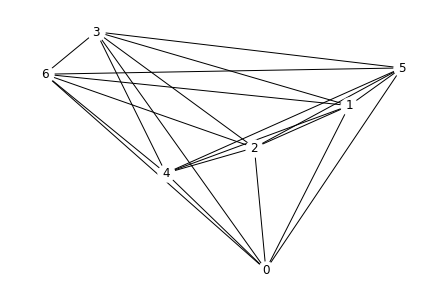

In [27]:
draw_solution (V, E, x)

Abbiamo un circuito hamiltoniano o abbiamo dei sottotour (indizio: cambiate il random seed prima di guardare questa parte)? In quest'ultimo caso, dobbiamo separare i vincoli di eliminazione del sottotour. Lo facciamo a mano, le iterazioni sono poche.

In [29]:
# TODO: eliminate i subtour, aggiungendo un vincolo
# Un esempio: se abbiamo un subtour costituito dagli archi [0,4], [4,6], [0,5] 
# e [5,6], dobbiamo imporre che la somma delle variabili x_ij ad esso correlato
# sia inferiore a 3, ovvero che tutti e quattro quegli archi non siano inclusi 
# nella soluzione


m.add_constr(x[2,5] + x[2,3] + x[3,5] <= 2)
m.add_constr(x[4,14]+x[13,14]+x[4,13]<=2)
m.add_constr(x[3,6]+x[3,12]+x[6,12]<=2)
m.add_constr(x[7,19]+x[19,23]+x[23,24]+x[7,24]<=3)
m.optimize()
draw_solution (V, E, x)

KeyError: (4, 14)

Servono altri vincoli?

In [ ]:
# TODO: Indizio, sì. Ne serve ancora uno, scrivetelo qui e ammirate il vostro
# ciclo Hamiltoniano

m.add_constr(x[1,17]<=2)
m.optimize()
draw_solution(V,E,x)